# Averaged Artifact Substraction with EEG Data
## First step prepare Jupyter Notebook

In [1]:
import os
from FACET.Facet import Facet
from loguru import logger
import sys

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))

eegDataSet_filepath = "NiazyFMRI.edf"
motiondata_moosmann_filepath = "headmotiondata.tsv"
export_bids_path = "./bids_dir"

#configure logging
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("Facet.log", level="DEBUG")

#defining important parameters
window_size = 25 # defines the window size for averaging
upsampling_factor = 10 # defines the resampling factor
artifact_to_trigger_offset_seconds = -0.01 # defines the artifact position in seconds relative to the triggermark.
relative_window_position = -0.5 # defines the relative position of the averaging window over the epochs.
moosmann_motion_threshold = 0.8 # defines the threshold for moosmann which determines if a motion data entry is significant or not
event_id_description_pairs={'trigger':1} # For exporting as bids. It defines the event id and its description.
regex_trigger_annotation_filter = r'\btrigger\b' # Annotations with the description 'trigger' are considered as triggers, declard for find triggers after reimporting from bids
regex_trigger_event_filter = r'\b1\b' # Events with the value 1 are considered as triggers, declared for edf stim channel
unwanted_bad_channels = ['EKG', 'EMG', 'EOG', 'ECG'] # Channels with these names are considered as bad channels and not considered in the processing
evaluation_measures=["SNR", "RMS", "RMS2", "MEDIAN"] # Measures that must be calculated and used for evaluation.

f = Facet()


## Second Step import EEG Data

In [2]:
f.import_EEG(eegDataSet_filepath, artifact_to_trigger_offset=artifact_to_trigger_offset_seconds, upsampling_factor=upsampling_factor, bads=unwanted_bad_channels)
f.find_triggers(regex_trigger_event_filter)
eeg = f.get_EEG()
f.export_EEG(path="./export",fmt="bids", event_id=event_id_description_pairs)
f.import_EEG(path="./export",fmt="bids", artifact_to_trigger_offset=artifact_to_trigger_offset_seconds, bads=unwanted_bad_channels)
eeg = f.get_EEG()

f.plot_EEG(title="after import")

2024-03-26 11:03:12.013 | INFO     | FACET.Facet:import_EEG:18 - Importing EEG from NiazyFMRI.edf
2024-03-26 11:03:12.571 | INFO     | FACET.Facet:find_triggers:26 - finding triggers
2024-03-26 11:03:12.587 | INFO     | FACET.Facet:find_triggers:29 - Found 840 triggers
2024-03-26 11:03:12.589 | INFO     | FACET.Frameworks.Analytics:export_EEG:90 - Exporting Channels: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'AF4', 'AF3', 'FC2', 'FC1', 'CP1', 'CP2', 'PO3', 'PO4', 'FC6', 'FC5', 'CP5', 'EMG', 'ECG', 'Status']
2024-03-26 11:03:20.545 | INFO     | FACET.Facet:import_EEG:18 - Importing EEG from ./export


## Third Step Preprocessing

In [3]:
f.pre_processing()
f.get_correction().prepare_ANC()


2024-03-26 11:03:27.725 | INFO     | FACET.Frameworks.Correction:upsample:599 - Upsampling Data


## Fourth Step find triggers

In [4]:

f.find_triggers(regex_trigger_annotation_filter) # Using Niazys data
f.get_analytics().print_analytics()
eeg = f.get_EEG()


2024-03-26 11:03:37.284 | INFO     | FACET.Facet:find_triggers:26 - finding triggers
2024-03-26 11:03:37.651 | INFO     | FACET.Facet:find_triggers:29 - Found 840 triggers
2024-03-26 11:03:37.653 | INFO     | FACET.Frameworks.Analytics:print_analytics:321 - Analytics:
2024-03-26 11:03:37.654 | INFO     | FACET.Frameworks.Analytics:print_analytics:322 - Number of Triggers found: 840
2024-03-26 11:03:37.655 | INFO     | FACET.Frameworks.Analytics:print_analytics:323 - Art Length: 3030
2024-03-26 11:03:37.658 | INFO     | FACET.Frameworks.Analytics:print_analytics:324 - Duration of Art in seconds: 0.14794921875
2024-03-26 11:03:37.667 | INFO     | FACET.Frameworks.Analytics:print_analytics:331 - Time Start: 0.0 s
2024-03-26 11:03:37.676 | INFO     | FACET.Frameworks.Analytics:print_analytics:332 - Time End: 162.999951171875 s
2024-03-26 11:03:37.677 | INFO     | FACET.Frameworks.Analytics:print_analytics:333 - Sampling Frequency: 20480.0 Hz
2024-03-26 11:03:37.678 | INFO     | FACET.Frame

## Fourth step apply AAS

In [5]:
f.apply_AAS(window_size=window_size, rel_window_position=relative_window_position)

2024-03-26 11:03:37.702 | INFO     | FACET.Facet:apply_AAS:33 - Applying AAS with method numpy


## Fifth step Remove Artifacts

In [6]:
f.remove_artifacts( )
eeg = f.get_EEG()



## Sixth step Post-Processing

In [7]:
f.post_processing()

2024-03-26 11:03:53.265 | INFO     | FACET.Frameworks.Correction:downsample:588 - Downsampling Data


## Seventh display the processed eeg data

In [8]:
f.plot_EEG(title="after lowpass")

## Eighth Evaluate Results

2024-03-26 11:06:50.712 | INFO     | FACET.Facet:add_to_evaluate:68 - Adding to evaluation...
2024-03-26 11:06:50.949 | INFO     | FACET.Facet:evaluate:71 - Evaluating...


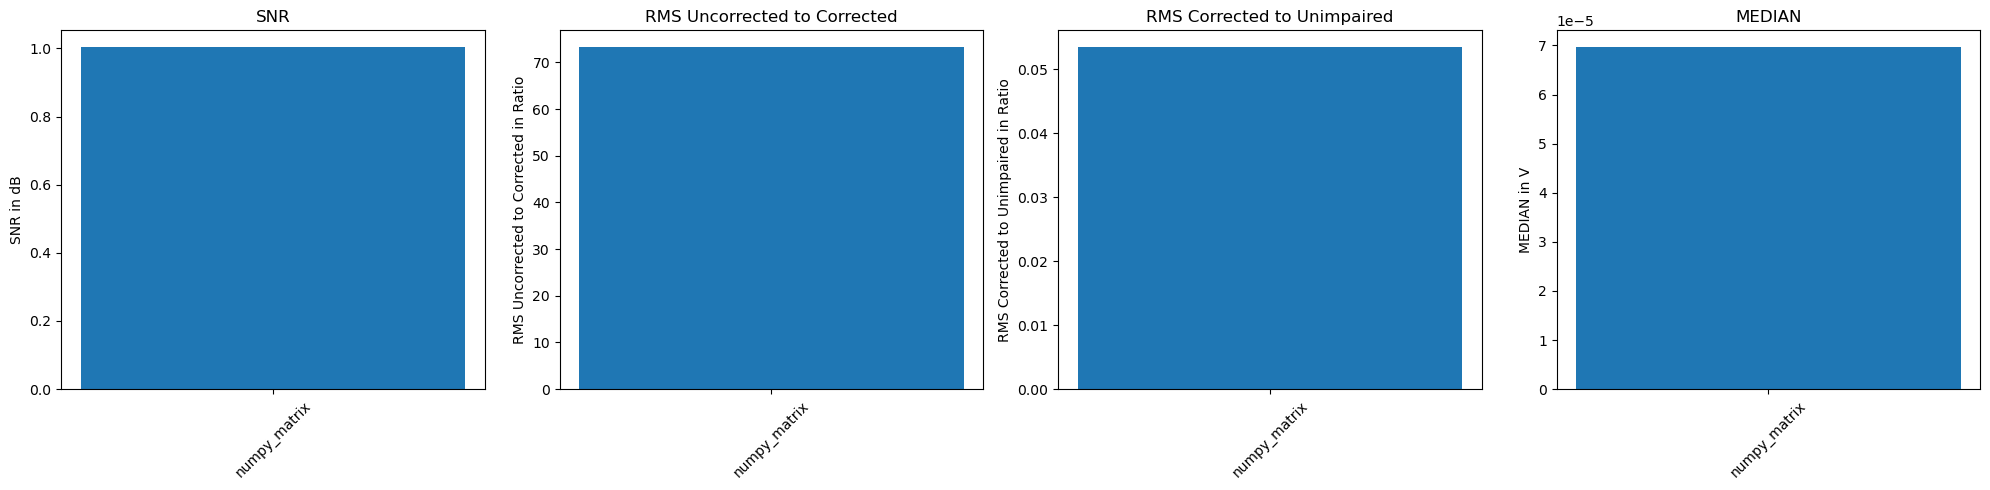

2024-03-26 11:06:51.952 | INFO     | __main__:<module>:3 - [{'Measure': 'SNR', 'Values': [1.0028656151874384], 'Unit': 'dB'}, {'Measure': 'RMS Uncorrected to Corrected', 'Values': [73.19165582500324], 'Unit': 'Ratio'}, {'Measure': 'RMS Corrected to Unimpaired', 'Values': [0.053448121078470176], 'Unit': 'Ratio'}, {'Measure': 'MEDIAN', 'Values': [6.960448368056234e-05], 'Unit': 'V'}]
2024-03-26 11:09:31.598 | INFO     | FACET.Facet:add_to_evaluate:68 - Adding to evaluation...
2024-03-26 11:09:31.854 | INFO     | FACET.Facet:evaluate:71 - Evaluating...


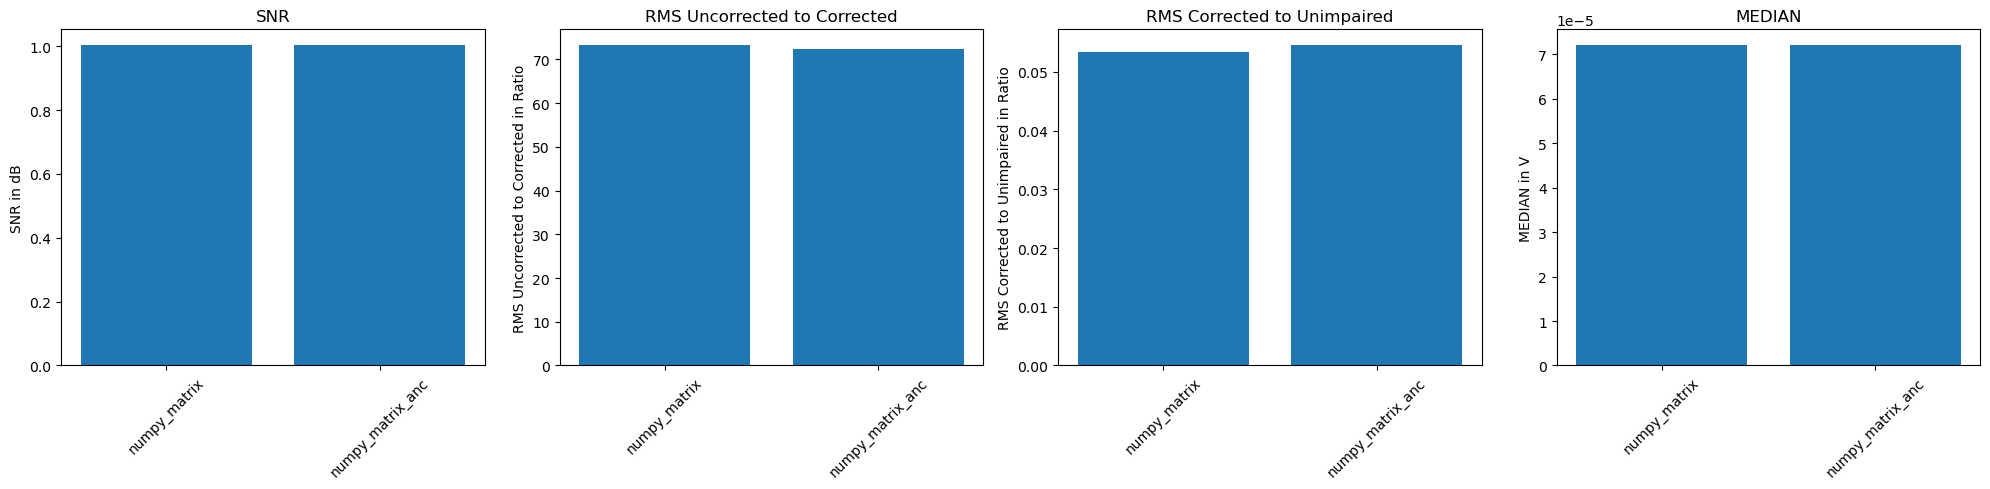

2024-03-26 11:09:33.464 | INFO     | __main__:<module>:6 - [{'Measure': 'SNR', 'Values': [1.0028656151874384, 1.0029816212741658], 'Unit': 'dB'}, {'Measure': 'RMS Uncorrected to Corrected', 'Values': [73.19165582500324, 72.40967864028966], 'Unit': 'Ratio'}, {'Measure': 'RMS Corrected to Unimpaired', 'Values': [0.053448121078470176, 0.054517220384376466], 'Unit': 'Ratio'}, {'Measure': 'MEDIAN', 'Values': [7.2025639927805e-05, 7.2025639927805e-05], 'Unit': 'V'}]
2024-03-26 11:09:33.484 | INFO     | FACET.Frameworks.Analytics:export_EEG:90 - Exporting Channels: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'AF4', 'AF3', 'FC2', 'FC1', 'CP1', 'CP2', 'PO3', 'PO4', 'FC6', 'FC5', 'CP5', 'EMG', 'ECG']


In [9]:
eeg_python = f.get_EEG()
f.add_to_evaluate(eeg_python, name="numpy_matrix") # Matrix will result in >1.0 RMS2 because of python mne inaccuracies
logger.info(f.evaluate(measures=evaluation_measures))
f.get_correction().apply_ANC()#applying ANC
f.add_to_evaluate(f.get_EEG(), name="numpy_matrix_anc")
logger.info(f.evaluate(measures=evaluation_measures))
f.export_EEG(event_id=event_id_description_pairs, path=export_bids_path, fmt="bids")

